# Walmart Dataset Solution - xgboost

This notebook and others can be downloaded from [here](https://github.com/shment/shment.github.io).

Walmart [dataset](https://www.kaggle.com/datasets/yasserh/walmart-dataset) consist of the weekly sales in different Walmart stores from 2010-02-05 to 2012-11-01. Our goal here is to predict the sales for a given week.
In this notebook we will see how to:
1. load data stored in a csv file to pandas dataframe
2. convert categorical to numeric features using scikit learn
3. handle date feature 
4. learn xgboost model to predict the sales
5. use optuna for hyper parameters tuning
6. save and load the model and other auxiliaries for inference on new samples 

First we will import the libraries we will use:

In [75]:
import numpy as np
import joblib
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import optuna
import matplotlib.pyplot as plt

Next we load the data to pandas dataframe and separate the target variable(weekly sales) from the rest.

In [76]:
df_x = pd.read_csv('/kaggle/input/walmart-dataset/Walmart.csv')
df_y = df_x['Weekly_Sales']
df_x = df_x.drop(columns=['Weekly_Sales'])

Here we check for problems in the data such as nan values and wrong data type.

In [77]:
pd.concat([df_x.nunique(axis=0), df_x.isna().sum(axis=0), df_x.dtypes], axis=1).rename(columns={0: 'uniques', 1:'na', 2:'type'})

,uniques,na,type
Store,45,0,int64
Date,143,0,object
Holiday_Flag,2,0,int64
Temperature,3528,0,float64
Fuel_Price,892,0,float64
CPI,2145,0,float64
Unemployment,349,0,float64


The data don't have nan values, but the *Store* and *Holiday_Flag* features need to be categorical - there is no sense in "store 1 is bigger then store 0". In addition, the *Date* feature has order - 2010-02-05 is before 2010-02-06, so we need to convert it to numerical feature in a way that will that into account. In addition, the month and the year has valuable information that we want to keep (November sales are probably higher). Simple way for doing that is to create 3 new features - *day*, *month* and *year*. If we needed to predict daily sales, since there is likely a correlation between the week day and the sales, we should have added another feature for the weekday (Sunday, Monday,...). However, since we are predicting weekly sales, it has no meaning for our problem.

In [78]:
df_x['Store'] = df_x['Store'].astype(object)
df_x['Holiday_Flag'] = df_x['Holiday_Flag'].astype(object)

df_x['Date'] = pd.to_datetime(df_x['Date'])
df_x['day'] = df_x['Date'].dt.day
df_x['month'] = df_x['Date'].dt.month
df_x['year'] = df_x['Date'].dt.year

df_x = df_x.drop(columns=['Date'])

Split the data to train and test sets.

In [79]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=1)

In the first line of the next cell, we get the list of the categorical features names. 
In order to convert the categorical features to numeric ones, we use one hot encoding.

In [80]:
categorical_features = list(x_train.loc[:, x_train.dtypes == object])
cat_encoder = OneHotEncoder()
cat_encoder.fit(x_train.loc[:, categorical_features])
transformed = cat_encoder.transform(x_train.loc[:, categorical_features].to_numpy())
ohe = pd.DataFrame(transformed.toarray(), columns=cat_encoder.get_feature_names_out())
x_train = x_train.reset_index()
x_train = pd.concat([x_train, ohe], axis=1)
x_train = x_train.drop(columns=categorical_features)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


Now our data is ready to use. 
Next thing we do is to search for the best hyper parameters for our xgboost model. The way we do that with optuna is by implementing *objective* function that will output a number corresponding with how good the chosen hyperparameters were. Here we output the mean absolute error.
Later we create a *study* object, and since lower mean absolute error is better we give it *direction="minimize"*. The *n_trials* parameter needs to be as high as you can afford. In order to make this cell run faster, I set it to 1. 

In [81]:
def objective(trial, x, y):
    xx_train, xx_val, yy_train, yy_val = train_test_split(x, y, test_size=0.1, random_state=1)
    dtrain = xgb.DMatrix(xx_train, label=yy_train)
    dval = xgb.DMatrix(xx_val, label=yy_val)

    param = {
        "objective": "reg:squarederror",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1.0, log=True)
    }

    bst = xgb.train(param, dtrain, num_boost_round=100)
    preds = bst.predict(dval)
    loss = mean_absolute_error(yy_val, preds)
    return loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, x_train, y_train), n_trials=1)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-01-31 13:46:54,615] A new study created in memory with name: no-name-98d1826e-4e56-4d03-b1a2-b5cfa0cd67aa
[I 2023-01-31 13:47:03,821] Trial 0 finished with value: 69094.94863577587 and parameters: {'booster': 'dart', 'lambda': 0.0009786247259208748, 'alpha': 6.249689047187643e-05, 'max_depth': 15, 'gamma': 1.4599709265223787e-08, 'grow_policy': 'lossguide', 'learning_rate': 0.08394146026853425}. Best is trial 0 with value: 69094.94863577587.


Number of finished trials:  1
Best trial:
  Value: 69094.94863577587
  Params: 
    booster: dart
    lambda: 0.0009786247259208748
    alpha: 6.249689047187643e-05
    max_depth: 15
    gamma: 1.4599709265223787e-08
    grow_policy: lossguide
    learning_rate: 0.08394146026853425


Now that we have the hyperparameters for our model, we can learn one.
The hyperparameters specified here are the output optuna gave after 100 trails. Usually higher *n_estimators* results in a better model, so we increase it to the largest value we can afford.

In [82]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         reg_lambda=0.2570131417683139,
                         alpha=0.0036109145652048207,
                         max_depth=8,
                         gamma=0.0054382741007995014,
                         grow_policy='lossguide',
                         booster='dart',
                         learning_rate=0.1618795141355424)
model.fit(x_train, y_train)

XGBRegressor(alpha=0.0036109145652048207, base_score=0.5, booster='dart',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=1, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.0054382741007995014, gpu_id=-1, grow_policy='lossguide',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1618795141355424, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.00361091457, ...)

Now that the model is ready, we can save it and the one hot encoder for future use.

In [83]:
joblib.dump(model, 'model.joblib')
joblib.dump(cat_encoder, 'cat_encoder.joblib')
joblib.dump(categorical_features, 'categorical_features.joblib')

['categorical_features.joblib']

Here is how to use the model on new data.
We load the model and encoder and transform the data the same way we did for train set.


In [84]:
model = joblib.load('model.joblib')
cat_encoder = joblib.load('cat_encoder.joblib')
categorical_features = joblib.load('categorical_features.joblib')

df_inference = x_test.copy()

transformed = cat_encoder.transform(x_test.loc[:, categorical_features].to_numpy())
ohe = pd.DataFrame(transformed.toarray(), columns=cat_encoder.get_feature_names_out())
x_test = x_test.reset_index()
x_test = pd.concat([x_test, ohe], axis=1)
x_test = x_test.drop(columns=categorical_features)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  "X does not have valid feature names, but"


Now we can use our model to predict weekly sales of the new data.
For debuging, we can save our predictions in a csv file.

In [85]:
test_pred = model.predict(x_test)
mae = mean_absolute_error(test_pred, y_test)
mape = mean_absolute_percentage_error(test_pred, y_test)
print('MAE:', mae)
print('MAPE:', mape)
df_inference['pred'] = test_pred
df_inference['mae'] = np.abs(test_pred - y_test)
df_inference['mape'] = mae / y_test
df_inference.to_csv('df_inference.csv', index=False)

MAE: 40504.16714091614
MAPE: 0.03825470121410209


The following figure shows that prediction of weekly sales for some stores are harder.

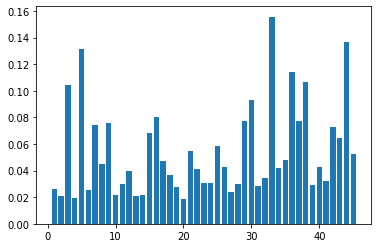

In [86]:
df_groupby_store = df_inference.groupby(['Store']).mean()
fig, ax = plt.subplots()
ax.bar(df_groupby_store.index, df_groupby_store['mape'])
fig.show()